In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
import math
import quantecon as qe
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
def create_bayesian_table(directory, name, experiment_per_generation, experiments, elements, activity, factor = 1):
    df = pd.read_csv(str(directory) + str(name) + '.txt', sep='\t')
    df = df[0:experiments]
    x_old = df[elements].to_numpy()
    x_old = np.around(x_old, decimals = 3)
    
    ID = list(range(1, experiment_per_generation+1))*(math.ceil(len(df)/experiment_per_generation))
    ID = np.array(ID[0:len(df)])

    gen = []
    for i in range(math.ceil(len(df)/experiment_per_generation)):
        gen.append([i]*experiment_per_generation)
    gen = np.array(gen)
    gen = np.reshape(gen, -1)
    gen = gen[0:len(df)]
    
    data = {'ID' : ID, 'Elements': [elements], 'Generation': gen}
    datalog = pd.DataFrame(data=data, index = np.arange(len(df)))
    datalog = pd.concat([datalog, pd.DataFrame(([[i] for i in x_old]), columns = ['Position'])], axis = 1)
    datalog['Activity'] = df[str(activity)] * factor
    return datalog

def data_parity_BO(label, 
                   load_location,
                   experiment_per_generation,
                   total_experiments,
                   element,
                   grid_len,
                   save_location,
                   grid_location,
                   upper_boundaries,
                   max_activity,
                   name,
                   length_scale):
    datalog = create_bayesian_table(directory = '../raw_data/composition_vs_activity/' + load_location,
                                    name = label,
                                    experiment_per_generation = experiment_per_generation,
                                    experiments = total_experiments,
                                    elements = element,
                                    activity = 'Activity',
                                    factor = -1)



    #Preaparing data for fitting
    x = []
    for i in range(len(datalog)):
        x.append(list(datalog['Position'][i]))
    x = np.array(x)
    y = datalog['Activity'].to_numpy()

    #GPR model
    kernel = RBF(length_scale = length_scale, length_scale_bounds = 'fixed') + WhiteKernel()
    gpr = GaussianProcessRegressor(kernel = kernel, random_state=0, normalize_y=True).fit(x, y)

    #Create Grid Data based on GPR
    elements = len(element)
    grid_len = grid_len
    grid = qe.simplex_grid(elements, grid_len)/grid_len
    element = element

    act = []
    for i in grid:
        act.append(float(gpr.predict(np.reshape(i, (1, -1)))))
    data_grid = pd.DataFrame(grid, columns = [element])
    data_grid = data_grid.assign(Activity = act)
    data_grid.to_csv(save_location, sep='\t', mode='w')

    #Try to remove the data outside the boundaries
    df = pd.read_csv(save_location, sep='\t')
    df = df.drop(['Unnamed: 0'], axis=1)

    for i in element:
        df = df.drop(df[df[i] > upper_boundaries].index)

    #Index need to be removed after removing some 
    df = df.reset_index(drop='True')

    #Real Grid
    real_grid = pd.read_csv(grid_location, sep='\t')
    real_grid = real_grid.drop(['Unnamed: 0'], axis=1)

    for i in element:
        real_grid = real_grid.drop(real_grid[real_grid[i] > upper_boundaries].index)

    #Index need to be removed after removing some 
    real_grid = real_grid.reset_index(drop='True')
    
    #Converting result in np.array
    result = np.array([real_grid['Activity'], df['Activity']])
    result = result.T
    result = abs(result/max_activity)
    result = result[result[:, 1] > 0.5]
    length_scale = float(str(gpr.kernel_).split("length_scale=")[1].split(")")[0])
    return result, length_scale


def data_parity_PSO(load_location,
                    data_number,
                    element,
                    grid_len,
                    save_location,
                    grid_location,
                    upper_boundaries,
                    max_activity, name,
                    length_scale_bounds,
                    length_scale = 1):
    #Loading datalog
    datalog = pd.read_csv('../raw_data/composition_vs_activity/' + load_location, sep='\t')

    #Reading "Elements" columns from string to list
    datalog['Elements'] = datalog["Elements"].apply(lambda x: literal_eval(x))

    #Creating np.array of "Position" column and dropping the string type "Position" column
    position = []
    for k in range(len(datalog)):
        position.append(list(np.fromstring(datalog['Position'][k][1:-1], dtype=float, sep=' ')))
    position = np.array(position)
    datalog = datalog.drop(columns=['Position'])
    datalog = pd.concat([datalog, pd.DataFrame(([[k] for k in position]), columns = ['Position'])], axis = 1)

    datalog = datalog.loc[0:data_number]


    #Preparing data for fitting
    x = []
    for i in range(len(datalog)):
        x.append(list(datalog['Position'][i]))
    x = np.array(x)
    y = datalog['Activity'].to_numpy()

    #GPR model
    kernel = RBF(length_scale = length_scale, length_scale_bounds = length_scale_bounds) + WhiteKernel()
    gpr = GaussianProcessRegressor(kernel = kernel, random_state=0, normalize_y=True).fit(x, y)

    
    #Create Grid Data based on GPR
    grid_len = grid_len
    grid = qe.simplex_grid(len(element), grid_len)/grid_len
    element = element

    act = []
    for i in grid:
        act.append(float(gpr.predict(np.reshape(i, (1, -1)))))
    data_grid = pd.DataFrame(grid, columns = [element])
    data_grid = data_grid.assign(Activity = act)
    data_grid.to_csv(save_location, sep='\t', mode='w')

    #Try to remove the data outside the boundaries
    df = pd.read_csv(save_location, sep='\t')
    df = df.drop(['Unnamed: 0'], axis=1)

    for i in element:
        df = df.drop(df[df[i] > upper_boundaries].index)

    #Index need to be removed after removing some 
    df = df.reset_index(drop='True')

    #Real Grid
    real_grid = pd.read_csv(grid_location, sep='\t')
    real_grid = real_grid.drop(['Unnamed: 0'], axis=1)

    for i in element:
        real_grid = real_grid.drop(real_grid[real_grid[i] > upper_boundaries].index)

    #Index need to be removed after removing some 
    real_grid = real_grid.reset_index(drop='True')
    
    #Converting result in np.array
    result = np.array([real_grid['Activity'], df['Activity']])
    result = result.T
    result = abs(result/max_activity)
    result = result[result[:, 1] > 0.5]
    length_scale = float(str(gpr.kernel_).split("length_scale=")[1].split(")")[0])
    return result, length_scale

In [3]:
def calculate_error(result):
    #Calculating MAE
    GP_AE = abs(result[:, 0] - result[:, 1])
    mae = round(GP_AE.mean(), 4)
    
    #Calculating R-squared
    r_square = round(r2_score(result[:, 1], result[:, 0]), 3)
    
    #Calculating RMSE
    rmse = round(np.sqrt(mean_squared_error(result[:, 1], result[:, 0])), 4)
    
    return np.array([mae, r_square, rmse])

In [4]:
def plot_parity_3(parity_data_0, parity_data_1, parity_data_2,
                  error_0, error_1, error_2,
                  data_number):
    
    #Plotting information
    fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (6, 2.5), sharex = True, sharey = True, dpi = 250)
    position = [axs[0], axs[1], axs[2]]
    min_value = 0.45
    max_value = 1.05
    x_data = np.linspace(min_value, max_value)
    y_data = np.linspace(min_value, max_value)
    
    #Plotting
    for i in range(3):
        ax = position[i]
        ax.plot(x_data, y_data, ls="-", color = 'black')
        ax.fill_between(x_data, (y_data - 0.1*(max_value-min_value)), (y_data + 0.1*(max_value-min_value)), color = 'red', alpha=0.2)
        ax.scatter(abs(locals()['parity_data_' + str(i)][0][:, 0]), locals()['parity_data_' + str(i)][0][:, 1], s=1)
        ax.text(0.46, 0.9, r'$R^2 = $' + str(locals()['error_' + str(i)][1]) +
                '\nMAE = ' + str(locals()['error_' + str(i)][0]) + 
                '\nLength Scale = ' + str(locals()['parity_data_' + str(i)][1]) +
                '\nSamples = ' + str(data_number[i]), fontsize = 7)
        ax.set_ylim(min_value, max_value)
        ax.set_xlim(min_value, max_value)
        ax.set_xticks((0.5, 1), fontsize = 8)
        ax.set_yticks(np.arange(0.5, 1.1, 0.25), fontsize = 8)
        if i == 1:
            ax.set_title('Model 3 (PSO)', fontsize = 11) #Change to BO if BO
            ax.set_xlabel('Calculated by DFT/Model', fontsize = 11)
        if i == 0:
            ax.set_ylabel('Predicted by GP', fontsize = 11)
     
    #Labelling
    plt.subplots_adjust(wspace=0.08, hspace=0.16)

    plt.show()
    return

In [5]:
models = ['model1', 'model2', 'model3', 'model4']
elements = [['Ag','Ir','Pd','Pt','Ru'], ['Ag','Ir','Pd','Pt','Ru'], ['Ir','Pd','Pt','Rh','Ru'], ['Pt','Pd','Au','Ru','Rh','Ir','Re','Os']]
max_activity = [0.163182, 0.213387, 0.167831, 1.039926]
name = ['PSO Neural Network', 'PSO DFT [Ag,Ir,Pd,Pt,Ru]', 'PSO DFT [Ir,Pd,Pt,Rh,Ru]', 'PSO Experimental']
scale = np.arange(0.1, 0.55, 0.02)
upper_boundaries = [0.8, 1, 1, 1]
grid_len = [20, 20, 20, 10]

selected_data_number = [15, 50, 100]

# Parity Model 3 (PSO)

In [ ]:
#Importing optimized length scale
method = 'k-fold_random'
data_type = 'PSO'
selected_data_number = [15, 50, 100]

for j in range(3):
    globals()[f"result_{j}"] = pd.read_csv('../result/LS_optimization/' +
                                                 str(data_type) +  '/' + str(method) +
                                                 '_model_3' + 
                                                 '_data_number_' + str(selected_data_number[j]) + '.txt', sep='\t')

#Selecting best length scale
length_scale = []
for i in range(3):
    length_scale.append(globals()['result_' + str((i))].iloc[np.where(globals()['result_' + str((i))]['MAE'] == globals()['result_' + str((i))]['MAE'].min())[0].max()]['Length Scale'])
length_scale = np.array(length_scale)

In [7]:
#Making parity data
#HP 3 is chosen -> str(2)
#For model 3 -> n = 2
#grid_data_19 = grid with 5% steps
data_location = '/PSO/PSO_' + str(2) + '_0.txt'
n=2
for i in range(3): 
    locals()['parity_data_' + str((i))] = data_parity_PSO(load_location = str(models[n]) + data_location,
                                                                data_number = selected_data_number[i],
                                                                element = elements[n],
                                                                grid_len = grid_len[n],
                                                                save_location = '../result/grid_data/' + str(models[n]) + '/grid_data_gpr.txt',
                                                                grid_location = '../result/grid_data/' + str(models[n]) + '/grid_data_19.txt',
                                                                upper_boundaries = upper_boundaries[n],
                                                                max_activity = max_activity[n],
                                                                name = name[n],
                                                                length_scale = length_scale[(i)],
                                                                length_scale_bounds = 'fixed')
    locals()['error_' + str((i))] = calculate_error(locals()['parity_data_' + str(i)][0])

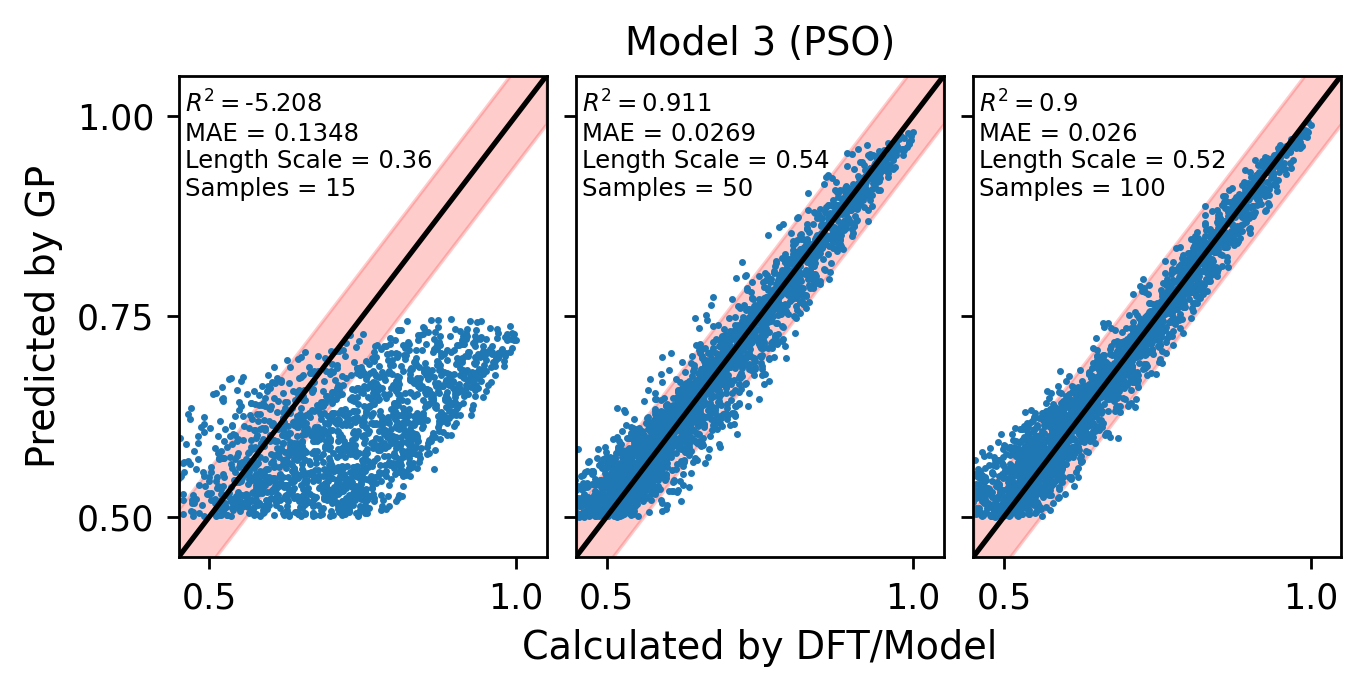

In [8]:
plot_parity_3(parity_data_0, parity_data_1, parity_data_2,
              error_0, error_1, error_2,
              data_number = [15, 50, 100])

# Parity Model 3 (BO)

In [9]:
method = 'k-fold_random'
data_type = 'BO'
selected_data_number = [15, 50, 100]

for j in range(3):
    globals()[f"result_BO{j}"] = pd.read_csv('../result/LS_optimization/' +
                                                    str(data_type) +  '/' + str(method) +
                                                    '_model_' + str(i+1) + 
                                                    '_data_number_' + str(selected_data_number[j]) + '.txt', sep='\t')

#Selecting best length scale
length_scale = []
for i in range(3):
    length_scale.append(globals()['result_BO' + str((i))].iloc[np.where(globals()['result_BO' + str((i))]['MAE'] == globals()['result_BO' + str((i))]['MAE'].min())[0].max()]['Length Scale'])
length_scale = np.array(length_scale)

In [12]:
#HP 3 is chosen -> str(2)
#For model 3 -> n = 2
#grid_data_19 = grid with 5% steps
n = 2
for i in range(3): 
    locals()['parity_data_' + str((i))] = data_parity_BO(label = 'result_1',
                                                         load_location = str(models[n]) + '/BO/',
                                                         experiment_per_generation = 1,
                                                         total_experiments = selected_data_number[i],
                                                         element = elements[n],
                                                         grid_len = grid_len[n],
                                                         save_location = '../result/grid_data/' + str(models[n]) + '/grid_data_gpr_bayes.txt',
                                                         grid_location = '../result/grid_data/' + str(models[n]) + '/grid_data_19.txt',
                                                         upper_boundaries = upper_boundaries[n],
                                                         max_activity = max_activity[n],
                                                         name = name[n],
                                                         length_scale = length_scale[(i)])
    locals()['error_' + str((i))] = calculate_error(locals()['parity_data_' + str(i)][0])

c:\Users\ahmad.tirmidzi\Anaconda3\envs\temp2\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


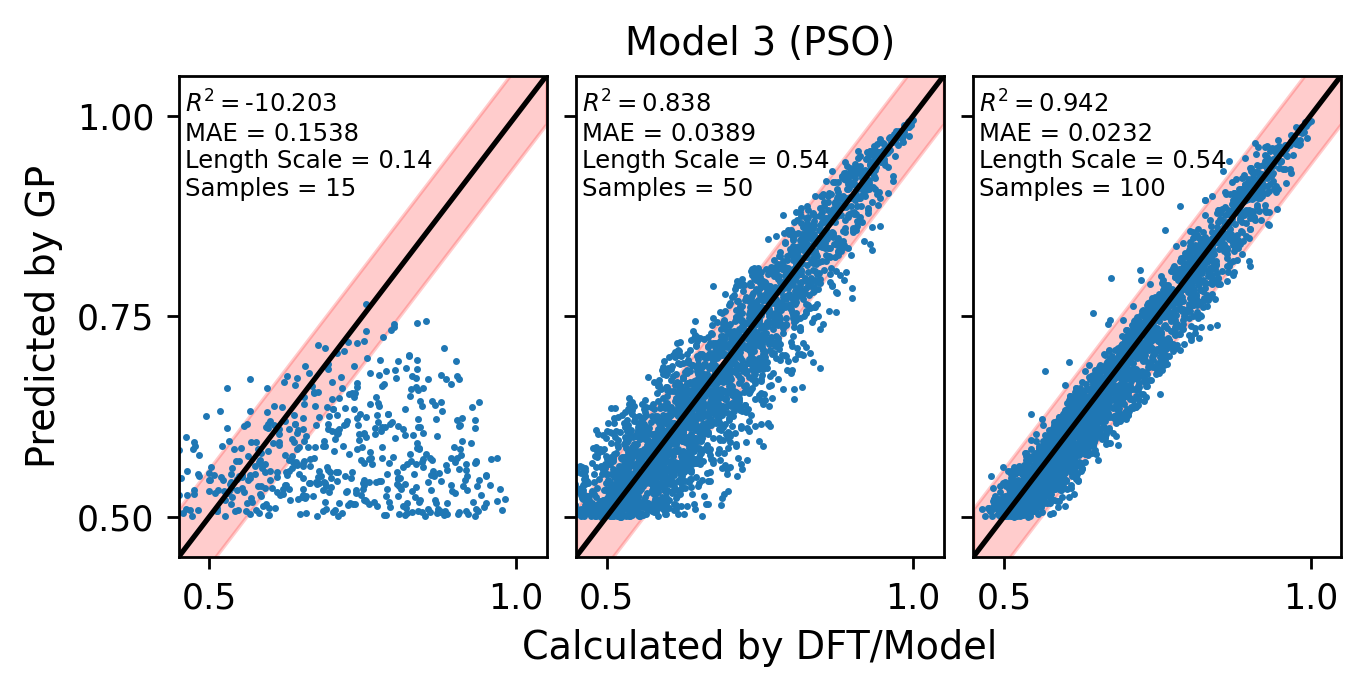

In [13]:
plot_parity_3(parity_data_0, parity_data_1, parity_data_2,
              error_0, error_1, error_2,
              data_number = [15, 50, 100])